# DNN 기반 이진분류 모델 구현 맟 학습 모니터링과 저장 
- 데이터셋 : iris.csv
- 피쳐 : 4개 sepal_length, sepal_width, petal_length, petal_width
- 타겟/라벨 : 1개 variety - Setosa
- 학습 방법 : 지도학습 - 회귀 
- 알고리즘 : 인공신경망(ANN) -> MLP(Multi Layer Perceptron), DNN ( ) : 은닉층이 많은 구성 
- 프레임 워크 : Pytorch

## [1] 모듈 로딩 및 데이터 준비
---

In [1]:
# 모델 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# 성능지표 
from torchmetrics.classification import F1Score, BinaryF1Score
from torchmetrics.classification import BinaryConfusionMatrix 
from torchinfo import summary

# 데이터 처리 및 시각화  
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import * 

from sklearn.model_selection import train_test_split


In [2]:
# 활용 패키지 버전 체크 => 사용자 정의 함수로 구현하기 
print(f'torch v.{torch.__version__}')
print(f'pandas v.{pd.__version__}')

torch v.2.4.1
pandas v.2.0.3


In [3]:
# 데이터 로딩 
DATA_FILE = '../DATA/iris.csv'

# csv => DF
iris_df = pd.read_csv(DATA_FILE)

iris_df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [4]:
# 타겟 변경 => 정수화, 클래스 3개 => 2개 
iris_df['variety'].unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [5]:
iris_df['variety'] == 'Setosa'

0       True
1       True
2       True
3       True
4       True
       ...  
145    False
146    False
147    False
148    False
149    False
Name: variety, Length: 150, dtype: bool

In [6]:
iris_df['variety'] = (iris_df['variety'] == 'Setosa')
iris_df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,True
1,4.9,3.0,1.4,0.2,True
2,4.7,3.2,1.3,0.2,True
3,4.6,3.1,1.5,0.2,True
4,5.0,3.6,1.4,0.2,True
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,False
146,6.3,2.5,5.0,1.9,False
147,6.5,3.0,5.2,2.0,False
148,6.2,3.4,5.4,2.3,False


In [7]:
# 타겟 정수화 
labels = dict(zip(iris_df['variety'].unique().tolist(), range(3)))
print(f'Labels => {labels}')

Labels => {True: 0, False: 1}


In [8]:
iris_df['variety'] =iris_df['variety'].astype(int)
print(f'고유값 : ',iris_df['variety'].unique())
iris_df.head()

고유값 :  [1 0]


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


## [2] 모델 클래스 설계 및 정의 
- 클래스 목적 : iris 데이터를 학습 및 추론 목적 
- 클래스 이름 : iris_bs_model
- 부모 클래스 : nn.Module 
- 매개 변수 : 층 별 입출력 개수 고정하기 때문에 필요 x 
- 속성 / 필드 : features_df, target_df, n_rows, n_features (df만들 때 사용)
- 기능 / 역할 : __init__() : 모델 구조 생성 , forward : 순방향 학습 (오버라이딩(overriding조건 : 상속관계에서만 가능))
- 클래스 구조 
    - 입력층 : 입력 4개(피처)        출력 10개(퍼셉트론/뉴런 10개 존재)
    - 은닉층 : 입력 10개            출력 5개 (퍼셉트론/뉴런 30개 존재)
    - 출력층 : 입력 5개             출력 1개 (퍼셉트론/뉴런 1개 존재 : 이진분류)

- 활성화 함수 
    - 클래스 형태 ==> nn.MSELoss , nn.ReLU => _ _init_ _() 메서드 
    - 함수 형태 => torch.nn.functional 아래에 => forward() 메서드 

In [9]:
class iris_bs_model(nn.Module):
    
    # 모델 구조 구성 및 인스턴스 생성 및 메서드 
    def __init__(self):
        super().__init__()

        # 모델 구조 구성 
        self.in_layer = nn.Linear(4,10)
        self.hidden_layer = nn.Linear(10,5)
        self.out_layer = nn.Linear(5,1)

    # 순방향 학습 진행 메서드 
    def forward(self, input_data):

        # 입력층 
        y = self.in_layer(input_data) # f11w11 + f12w12 + f13w13 + b, ......., f101w101 + f102w102 + f103w103 + b
        y = F.relu(y)             # relu => y 값의 범위 : 0 <= y 

        # 은닉층 : 10개의 숫자 값(>=0)
        y = self.hidden_layer(y)  # f21w11 + f22w12 .... + f210w210 + b, ......., f230w201 + f230w202 ..... f230w210 + b
        # 데이터 1개 기준
        y = F.relu(y) 

        # 출력층 : 5개의 숫자 값(>=0)
        # self.out_layer(y)         # f31w31 + ...... f330w330 + b
        # 회귀라서 활성함수 사용 x -> 바로 return 

        return F.sigmoid(self.out_layer(y))


In [10]:
# 모델 인스턴스 생성 
model = iris_bs_model()
print(model)

iris_bs_model(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=1, bias=True)
)


In [11]:
# 모델 사용 메모리 정보 확인 

summary(model, input_size=(17,4)) 

Layer (type:depth-idx)                   Output Shape              Param #
iris_bs_model                            [17, 1]                   --
├─Linear: 1-1                            [17, 10]                  50
├─Linear: 1-2                            [17, 5]                   55
├─Linear: 1-3                            [17, 1]                   6
Total params: 111
Trainable params: 111
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## [3] 데이터셋 클래스 설계 및 정의
- 데이터셋 : iris.csv 
- 피쳐 개수 : 4개 
- 타겟 개수 : 1개 
- 클래스 이름 : iris_data_set
- 부모 클래스 : utils.data.Dataset 
- 속성 / 필드 : feature_df, target_df 
- 필수 메서드 
    - _ _init_ _(self) : 데이터셋 저장 및 전처리, 개발자가 필요한 속성 설정 
    - _ _len_ _(self) : 데이터의 개수 반환 
    - _ _ getItem_ _(self, index) : 특정 인덱스의 피쳐와 타겟 반환 

In [12]:
class iris_data_set(Dataset):
    def __init__(self, feature_df, target_df):
        self.feature_df = feature_df
        self.target_df = target_df
        self.n_rows = feature_df.shape[0]
        self.n_features = feature_df.shape[1]

    def __len__(self):
        return self.n_rows

    def __getitem__(self,index):
        
        # 텐서화 
        feature_ts = torch.FloatTensor(self.feature_df.iloc[index].values) # 시리즈라서 values() 사용해서 numpy -> tensor 
        target_ts = torch.FloatTensor(self.target_df.iloc[index].values)
                
        # 피쳐와 타겟 반환 
        return feature_ts, target_ts

In [13]:
# [테스트] 데이터셋 인스턴스 생성 

# - DF 에서 피쳐와 타겟 추출 
feature_df = iris_df[iris_df.columns[:-1]] # 2D 
target_df = iris_df[iris_df.columns[-1:]]  # 2D 

# 커스텀 데이터셋 인스턴스 생성 
iris_ds = iris_data_set(feature_df, target_df)

# 데이터로더 인스턴스 생성 
iris_dl = DataLoader(iris_ds)
for feature, label in iris_dl:
    print(feature.shape, label.shape, feature, label)
    break


torch.Size([1, 4]) torch.Size([1, 1]) tensor([[5.1000, 3.5000, 1.4000, 0.2000]]) tensor([[1.]])


## [4] 학습 준비 
- 학습 횟수 : EPOCH (처음부터 끝까지 학습할 단위)
- 배치 크기 : BATCH_SIZE (한 번에 학습할 데이터셋 양)
- 위치 지정 : DEVICE (텐서 저장 및 실행 위치 (GPU, CPU))
- 학습률 : 가중치와 절편 업데이트 시 경사하강법으로 업데이트 간격 설정 0.001 ~ 0.

In [14]:
# 학습 진행 관련 설정 
EPOCH = 1000
BATCH_SIZE = 10 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001 # hyper-parameter : 업데이트 간격  

- 인스턴스 / 객체 : 모델, 데이터셋, 최적화, 손실함수 ,(성능지표)  

In [15]:
# 모델 인스턴스 
model = iris_bs_model()

# 데이터셋 인스턴스 
iris_ds = iris_data_set(feature_df, target_df)

# 데이터로더 인스턴스 
iris_dl = DataLoader(iris_ds, batch_size=BATCH_SIZE)


In [23]:
# DS과 DL 인스턴스 
# - 학습용, 검증용, 테스트용 데이터 분리 

# 데이터셋 인스턴스 
x_train, x_test, y_train, y_test = train_test_split(feature_df, target_df, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state = 1)
print(f'{x_train.shape} {x_test.shape} {x_val.shape}')
print(f'{y_train.shape} {y_test.shape} {y_val.shape}')
print(f'{y_train.value_counts()/y_train.shape[0]} {y_test.value_counts()/y_train.shape[0]} {y_val.value_counts()/y_train.shape[0]}')
print(f'{type(x_train)} {type(x_test)} {type(x_val)}')
# iris_ds = iris_data_set(x_train, y_train)

# 학습용, 검증용 테스트용 데이터셋 
train_ds = iris_data_set(x_train, y_train)
val_ds = iris_data_set(x_val, y_val)
test_ds = iris_data_set(x_test, y_test)

# 학습용 데이터로더 인스턴스 
# iris_dl = DataLoader(iris_ds, batch_size=BATCH_SIZE)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)


(84, 4) (38, 4) (28, 4)
(84, 1) (38, 1) (28, 1)
variety
0          0.702381
1          0.297619
Name: count, dtype: float64 variety
0          0.297619
1          0.154762
Name: count, dtype: float64 variety
0          0.190476
1          0.142857
Name: count, dtype: float64
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


- 최적화, 손실함수 인스턴스 생성

In [17]:
# 최적화 인스턴스 => w, b 텐서 즉, model.parameters() 전달 
optimizer = optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스 => 분류 => 이진분류 BinaryCrossEntropyLoss => BCELoss 
#                            예측값은 확률값으로 전달 => sigmoid() AF 처리 후 전달 
req_loss = nn.BCELoss()

## [5] 학습 진행 

In [18]:
len(train_dl), train_dl.__len__() # __len__ 쓰면 len() 이 불림 

(9, 9)

In [19]:
train_ds.n_rows / BATCH_SIZE

8.4

-> 4개 학습이 덜 됨

In [20]:
import math as m
train_ds.n_rows / BATCH_SIZE, m.ceil(train_ds.n_rows/BATCH_SIZE), train_ds.feature_df.shape[0]

(8.4, 9, 84)

In [21]:
## 학습의 효과 확인 손실값과 성능평가값 저장 필요 
LOSS_HISTORY, SCORE_HISTORY = [[],[]],[[],[]]
CNT = len(train_dl)
print(f'CNT : {CNT}')
 
for epoch in range(EPOCH):

    # 학습 모드로 모델 설정 
    model.train()

    # 배치 크기 만큼 데이터 로딩해서 학습 진행 
    loss_total, score_total = 0,0
    for feature_ts, target_ts in train_dl: # iris_dl -> train_dl 

        # 학습 진행 
        pre_y = model(feature_ts)

        # 손실 계산  
        loss = req_loss(pre_y, target_ts)
        loss_total += loss.item() # tensor 라서 item으로 값 넣어야 함 

        # 성능 평가 계산 
        score = BinaryF1Score()(pre_y, target_ts) 
        score_total += score.item() # tensor 라서 item으로 값 넣어야 함 

        # 최적화 진행 
        optimizer.zero_grad()       
        loss.backward()
        optimizer.step()

    # 에포크 당 검증기능 
    # 모델 검증 모드 설정 
    model.eval()
    # 검증한 결과를 저장해야 함 

    with torch.no_grad():
        # 검증 데이터셋 
        val_feature_ts = torch.FloatTensor(val_ds.feature_df.values) # values쓰면 array 됨 -> torch사용 -> torch됨 
        val_target_ts = torch.FloatTensor(val_ds.target_df.values)

        # 평가 
        pre_val =model(val_feature_ts)
        
        # 손실 
        loss_val = req_loss(pre_val, val_target_ts)

        # 성능 평가 
        score_val = BinaryF1Score()(pre_val, val_target_ts)


    # for문 다 돌면 1 epoch 종료 
    # 손실값과 성능평가값 저장 
    LOSS_HISTORY[0].append(loss_total/CNT)
    SCORE_HISTORY[0].append(score_total/CNT)

    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTORY[1].append(score_val)

    print(f'[{epoch}/{EPOCH}]\n- Train Loss : {LOSS_HISTORY[0][-1]} Score : {SCORE_HISTORY[0][-1]}')
    print(f'- Val Loss : {LOSS_HISTORY[1][-1]} Score : {SCORE_HISTORY[1][-1]}')

CNT : 9
[0/1000]
- Train Loss : 1.3463615046607122 Score : 0.4377178516652849
- Val Loss : 1.1145743131637573 Score : 0.6000000238418579
[1/1000]
- Train Loss : 1.2223336299260457 Score : 0.4377178516652849
- Val Loss : 1.0276764631271362 Score : 0.6000000238418579
[2/1000]
- Train Loss : 1.1168813440534804 Score : 0.4377178516652849
- Val Loss : 0.9563011527061462 Score : 0.6000000238418579
[3/1000]
- Train Loss : 1.0288457075754802 Score : 0.4377178516652849
- Val Loss : 0.8982623219490051 Score : 0.6000000238418579
[4/1000]
- Train Loss : 0.9561630487442017 Score : 0.4377178516652849
- Val Loss : 0.8513818383216858 Score : 0.6000000238418579
[5/1000]
- Train Loss : 0.8963411185476515 Score : 0.4377178516652849
- Val Loss : 0.8137302994728088 Score : 0.6000000238418579
[6/1000]
- Train Loss : 0.8467613392406039 Score : 0.4377178516652849
- Val Loss : 0.7827134728431702 Score : 0.6000000238418579
[7/1000]
- Train Loss : 0.8034776714113023 Score : 0.4377178516652849
- Val Loss : 0.7551

- 학습 결과 체크 => 학습과 검증의 Loss 변화, 성능 변화

Text(0.5, 1.0, 'SCORE')

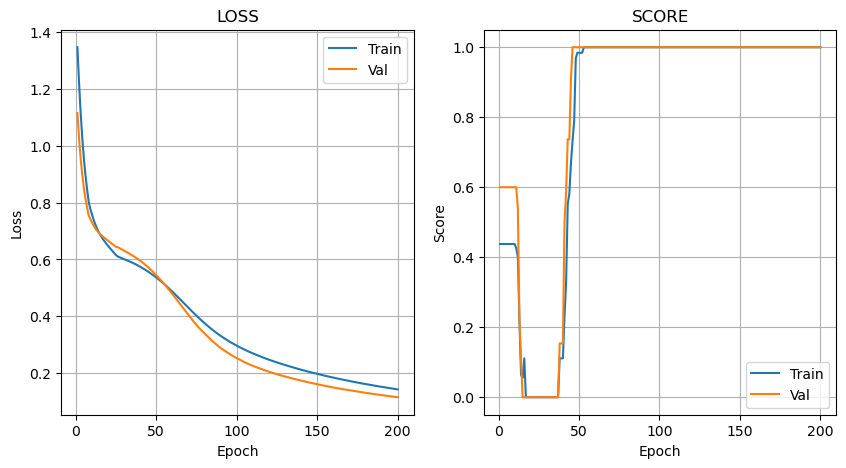

In [25]:
THRESHOLD = 200

fg, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].plot(range(1,THRESHOLD+1) ,LOSS_HISTORY[0][:THRESHOLD], label = 'Train')
axes[0].plot(range(1,THRESHOLD+1), LOSS_HISTORY[1][:THRESHOLD], label = 'Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('LOSS')

axes[1].plot(range(1,THRESHOLD+1) ,SCORE_HISTORY[0][:THRESHOLD], label = 'Train')
axes[1].plot(range(1,THRESHOLD+1), SCORE_HISTORY[1][:THRESHOLD], label = 'Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('SCORE')